In [104]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
from glob import glob
import cv2
import json

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

In [38]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [53]:
!head -n 100 model_data/yolo_anchors.txt

10,13,  16,30,  33,23,  30,61,  62,45,  59,119,  116,90,  156,198,  373,326


In [39]:
annotation_path = 'train.txt'
log_dir = 'logs/000/'
classes_path = 'model_data/voc_classes.txt'
anchors_path = 'model_data/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)

In [43]:
h = 256
w = h
num_anchors = len(anchors)
y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]
y_true

[<tf.Tensor 'input_7:0' shape=(None, 8, 8, 3, 25) dtype=float32>,
 <tf.Tensor 'input_8:0' shape=(None, 16, 16, 3, 25) dtype=float32>,
 <tf.Tensor 'input_9:0' shape=(None, 32, 32, 3, 25) dtype=float32>]

In [44]:
h = 512
w = h
num_anchors = len(anchors)
y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]
y_true

[<tf.Tensor 'input_10:0' shape=(None, 16, 16, 3, 25) dtype=float32>,
 <tf.Tensor 'input_11:0' shape=(None, 32, 32, 3, 25) dtype=float32>,
 <tf.Tensor 'input_12:0' shape=(None, 64, 64, 3, 25) dtype=float32>]

In [1]:
# !cat yolo3/utils.py

In [2]:
# !cat yolo3/model.py

# tutorial

## Quick Start

1. Download YOLOv3 weights from [YOLO website](http://pjreddie.com/darknet/yolo/).
2. Convert the Darknet YOLO model to a Keras model.
3. Run YOLO detection.

```
wget https://pjreddie.com/media/files/yolov3.weights
python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5
python yolo_video.py [OPTIONS...] --image, for image detection mode, OR
python yolo_video.py [video_path] [output_path (optional)]
```

In [34]:
!ls ../../datasets/bdd/bdd100k/images/100k/train/0000f77c-6257be58.jpg

../../datasets/bdd/bdd100k/images/100k/train/0000f77c-6257be58.jpg


### Inference all bdd img in 10k

In [47]:
%%bash
# source /root/.local/share/jupyter/kernels/voxelmorph_cpu/bin/activate

# pip install keras

# wget https://pjreddie.com/media/files/yolov3.weights
# python convert.py yolov3.cfg yolov3.weights model_data/yolo.h5
/root/miniconda3/envs/voxelmorph_cpu/bin/python yolo_video.py --input ../../datasets/bdd/bdd100k/images/100k/train --image-test true

test image
model_data/yolo.h5 model, anchors, and classes loaded.
['../../datasets/bdd/bdd100k/images/100k/train/0000f77c-6257be58.jpg', '../../datasets/bdd/bdd100k/images/100k/train/0000f77c-62c2a288.jpg', '../../datasets/bdd/bdd100k/images/100k/train/0000f77c-cb820c98.jpg', '../../datasets/bdd/bdd100k/images/100k/train/0001542f-5ce3cf52.jpg', '../../datasets/bdd/bdd100k/images/100k/train/0001542f-7c670be8.jpg', '../../datasets/bdd/bdd100k/images/100k/train/0001542f-ec815219.jpg', '../../datasets/bdd/bdd100k/images/100k/train/0004974f-05e1c285.jpg', '../../datasets/bdd/bdd100k/images/100k/train/00054602-3bf57337.jpg', '../../datasets/bdd/bdd100k/images/100k/train/00067cfb-5443fe39.jpg', '../../datasets/bdd/bdd100k/images/100k/train/00067cfb-5adfaaa7.jpg']
0000f77c-6257be58.jpg


2019-10-31 12:04:33.277371: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2019-10-31 12:04:33.312556: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2400000000 Hz
2019-10-31 12:04:33.320113: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561c6651ef30 executing computations on platform Host. Devices:
2019-10-31 12:04:33.320172: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2019-10-31 12:04:33.483738: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA

In [76]:
test_pathes = glob('./test_result/*.jpg')
len(test_pathes)

70000

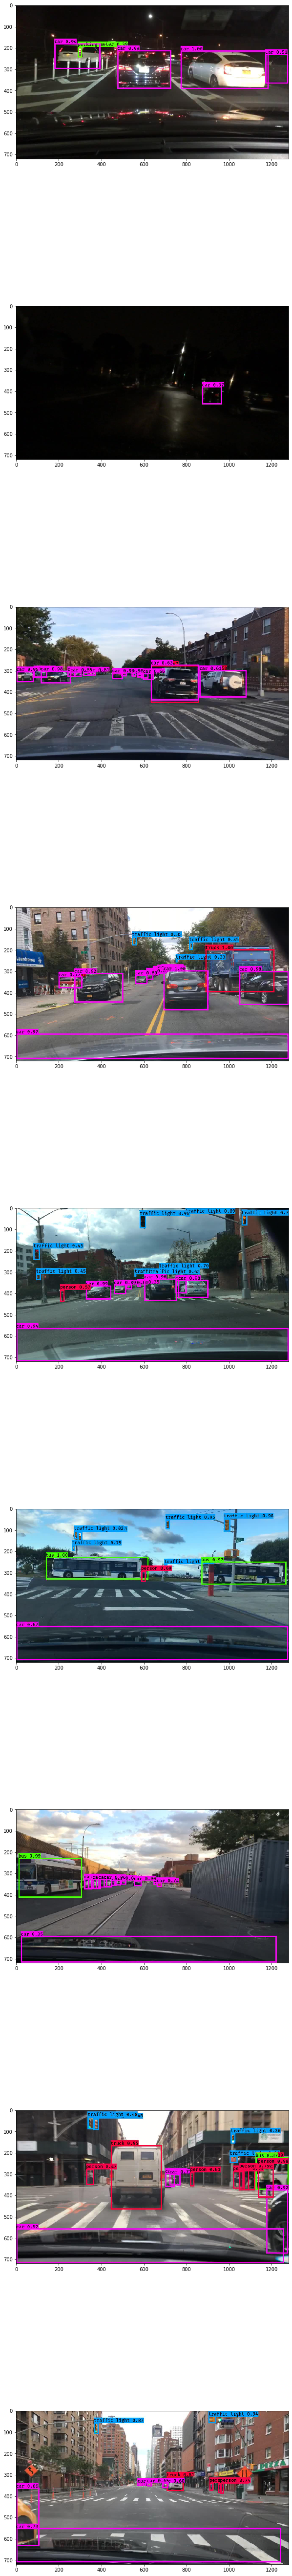

In [79]:
fig = plt.figure(figsize=(10, 100))
test_list = test_pathes[-10:-1]
max_len = len(test_list)
for idx, test_img in enumerate(test_list):
    fig.add_subplot(max_len, 1, idx+1)
    img = plt.imread(test_img)
    plt.imshow(img)

## make custom annotation

In [ ]:
# check coco annotation

## download coco annotation data
#!wget http://images.cocodataset.org/zips/val2017.zip
#!mv val2017.zip mscoco2017/
#!cd mscoco2017 && unzip val2017.zip
#!python coco_annotation_for_val.py

In [92]:
coco_classes = []
with open('model_data/coco_classes.txt', 'r') as f:
    for line in f.readlines():
        coco_classes.append(line.replace('\n', ''))

In [95]:
coco_classes[16]

'dog'

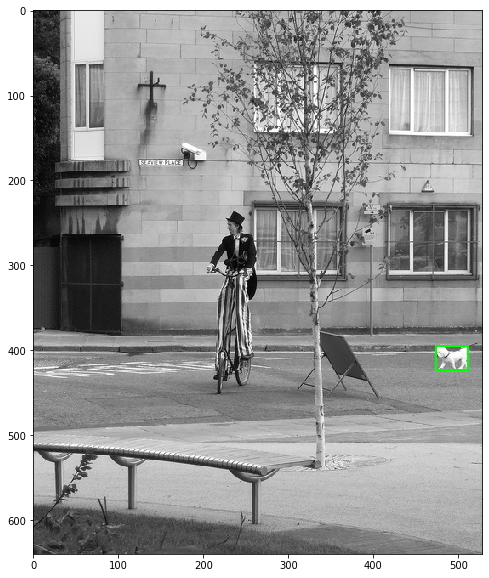

In [103]:
# annotation: mscoco2017/val2017/000000289343.jpg 473,395,511,423,16 204,235,264,412,0 0,499,339,605,13 204,304,256,456,1
fig = plt.figure(figsize=(10, 10))
img = cv2.imread('mscoco2017/val2017/000000289343.jpg')
img = cv2.rectangle(img, (473,395), (511,423), [0,255,0], 2)
plt.imshow(img)

In [108]:
# make bdd annotation
with open('../../datasets/bdd/bdd100k/labels/bdd100k_labels_images_train.json', 'r') as f:
    bdd_json = json.loads(f.read())

In [109]:
bdd_json[0]

{'name': '0000f77c-6257be58.jpg',
 'attributes': {'weather': 'clear',
  'scene': 'city street',
  'timeofday': 'daytime'},
 'timestamp': 10000,
 'labels': [{'category': 'traffic light',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'green'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1125.902264,
    'y1': 133.184488,
    'x2': 1156.978645,
    'y2': 210.875445},
   'id': 0},
  {'category': 'traffic light',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'green'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1156.978645,
    'y1': 136.637417,
    'x2': 1191.50796,
    'y2': 210.875443},
   'id': 1},
  {'category': 'traffic sign',
   'attributes': {'occluded': False,
    'truncated': False,
    'trafficLightColor': 'none'},
   'manualShape': True,
   'manualAttributes': True,
   'box2d': {'x1': 1101.731743,
    'y1': 211.122087,
    'x2': 1170.79037,
    

In [116]:
bdd_json[0]['name'], bdd_json[0]['labels'][0]['category'], bdd_json[0]['labels'][0]['box2d']

('0000f77c-6257be58.jpg',
 'traffic light',
 {'x1': 1125.902264, 'y1': 133.184488, 'x2': 1156.978645, 'y2': 210.875445})

In [138]:
bdd_classes = []
with open('./model_data/bdd_classes.txt', 'r') as f:
    for line in f.readlines():
        bdd_classes.append(line.replace('\n',''))
bdd_classes_dict = {}
for idx, cls in enumerate(bdd_classes):
    bdd_classes_dict.update({cls:str(idx)})
bdd_classes_dict

{'bike': '0',
 'bus': '1',
 'car': '2',
 'drivable area': '3',
 'lane': '4',
 'motor': '5',
 'person': '6',
 'rider': '7',
 'traffic light': '8',
 'traffic sign': '9',
 'train': '10',
 'truck': '11'}

In [150]:
img_data_path = '../../datasets/bdd/bdd100k/images/100k/train/'
with open('./model_data/bdd_train.txt', 'w') as f:
    for img_ano in bdd_json:
        img_name = img_ano['name']
        bboxes = []
        for obj in img_ano['labels']:
            try:
                obj['box2d']
            except:
                continue
            x1 = obj['box2d']['x1']
            y1 = obj['box2d']['y1']
            x2 = obj['box2d']['x2']
            y2 = obj['box2d']['y2']
            bboxes.append(str(int(x1))+','+str(int(y1))+','+str(int(x2))+','+str(int(y2))+','+bdd_classes_dict[obj['category']])
            
        f.write(img_data_path+img_name+' '+' '.join(bboxes)+'\n')

In [ ]:
# 학습에 사용할 모델 weight 파일 생성
!python convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5